# Slides Notebook for Neurohackademy 2019 Lecture on fMRI Models

This notebook contains code used to create some of the visualization in the slides used during the tutorial.

## Initialization

These cells copied from the `class-notebook.ipynb` Initialization section.

In [1]:
# Import some standard/utility libraries:
import os, sys, time, h5py
import six # six provides python 2/3 compatibility

# Import our numerical/scientific libraries, scipy and numpy:
import numpy as np
import scipy as sp

# The pimms (Python Immutables) library is a utility library that enables lazy
# computation and immutble data structures; https://github.com/noahbenson/pimms
import pimms

# The popeye library (https://github.com/kdesimone/popeye) is a pRF modeling
# library that we will use to obtain pRF parameters for the functional data
import popeye

# The neuropythy library is a swiss-army-knife for handling MRI data, especially
# anatomical/structural data such as that produced by FreeSurfer or the HCP.
# https://github.com/noahbenson/neuropythy
import neuropythy as ny

# Import graphics libraries:
# Matplotlib/Pyplot is our 2D graphing library:
import matplotlib as mpl
import matplotlib.pyplot as plt
# We also use the 3D graphics library ipyvolume for 3D surface rendering
import ipyvolume as ipv

In [2]:
# These "magic commands" tell matplotlib that we want to plot figures inline and
# That we are using qt as a backend; due to bugs in certain versions of
# matplotlib, we put them in a separate cell as the import statements above and
# the configuration statements below.
%gui qt
%matplotlib inline

In [3]:
# Additional matplotlib preferences:
font_data = {'family':'sans-serif',
             'sans-serif':['Helvetica Neue', 'Helvetica', 'Arial'],
             'size': 10,
             'weight': 'light'}
mpl.rc('font',**font_data)
# we want relatively high-res images, especially when saving to disk.
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['savefig.dpi'] = 72*4

## Configuration

In [5]:
# The subject ID we're using:
sid = 100610

# The BOLD images, for when we need them (loaded lazily)
exp_directions = ['EXP','CON','CW','CCW','BAR1','BAR2']
enc_dir = {'BAR1':'AP', 'BAR2':'PA', 'CCW': 'AP', 'CW':  'PA', 'EXP': 'AP', 'CON': 'PA'}
bold_images = {}
filename_patt = '/data/hcp/retinotopy/%d/tfMRI_RET%s_7T_%s_Atlas_1.6mm_MSMAll.dtseries.nii'
for exp_dir in exp_directions:
    filename = filename_patt % (sid, exp_dir, enc_dir[exp_dir])
    bold_images[exp_dir] = ny.util.curry(ny.load, filename, 'cifti', to='image')
# make into a lazy map:
bold_images = pimms.lazy_map(bold_images)
# now, here's how we concatenate these images into a single image
def _join_bold_images():
    bold_image = np.asarray([np.asarray(bold_images[k].dataobj) for k in exp_directions])
    # subtract the mean as a simple form of detrending between stimulus sets:
    bold_image = bold_image - np.reshape(np.mean(bold_image, axis=1), (len(bold_image), 1, -1))
    return np.vstack(bold_image)
bold_images = bold_images.set('all', _join_bold_images)
# Now bold_images['all'] will force loading of all images and return the full matrix
# We also want LH/RH/subcortical entries though:
bold_images = bold_images.set('split', lambda:ny.hcp.cifti_split(bold_images['all']))
bold_images = bold_images.set('lh', lambda:bold_images['split'][0])
bold_images = bold_images.set('rh', lambda:bold_images['split'][1])
bold_images = bold_images.set('subcortical', lambda:bold_images['split'][2])

# Load the stimulus, also lazily:
stimulus_arrays = {}
def _load_stimfile(filename):
    with h5py.File(filename, 'r') as fl:
        stim = np.asarray(fl['stim'])
    # We swap rows/cols here because matlab stores things in column-major order
    return np.transpose(stim / 255.0, [2,1,0])
for exp_dir in exp_directions:
    ed = 'BAR' if exp_dir.startswith('BAR') else exp_dir
    filename = '/data/hcp/retinotopy/apertures/RET%ssmall.mat' % ed
    stimulus_arrays[exp_dir] = ny.util.curry(_load_stimfile, filename)
stimulus_arrays = pimms.lazy_map(stimulus_arrays)    
# make one big stimulus array:
def _join_stimulus_arrays():
    stimulus_array = np.concatenate([stimulus_arrays[k] for k in exp_directions], axis=2)
    # we also want to downsample it to just 80x80 for the sake of speed:
    from skimage.transform import resize as skimresize
    stimulus_array = skimresize(stimulus_array, [80,80,stimulus_array.shape[-1]])
    return np.round(stimulus_array).astype('short') # convert in short integer
stimulus_arrays = stimulus_arrays.set('all', _join_stimulus_arrays)

## Example MR Images

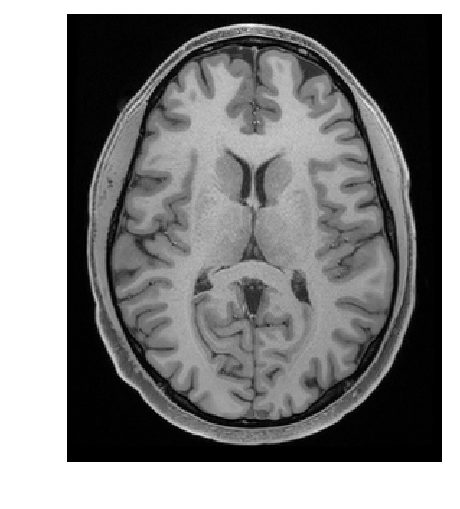

In [8]:
sub = ny.hcp_subject(sid)
imarr = np.asarray(sub.images['T1'].dataobj)

figsize = (imarr.shape[0]/100, imarr.shape[1]/100)
(fig,ax) = plt.subplots(1,1, figsize=figsize)
ax.imshow(imarr[:,:,120].T, cmap='gray')
ax.axis('off')
ax.invert_yaxis()
fig.subplots_adjust(0,0,1,1,0,0)

In [19]:
ribbon = np.asarray(sub.images['ribbon'].dataobj)
# FreeSurfer uses these numbers for some reason I don't understand:
white_mask = (ribbon == 2) | (ribbon == 41)
gray_mask  = (ribbon == 3) | (ribbon == 42)

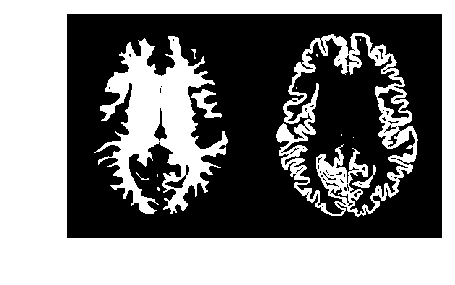

In [21]:
figsize = (imarr.shape[0]/100, 2*imarr.shape[1]/100)
(fig,axs) = plt.subplots(1,2, figsize=figsize)
for (ax,im) in zip(axs, [white_mask, gray_mask]):
    ax.imshow(im[:,:,120].T, cmap='gray')
    ax.axis('off')
    ax.invert_yaxis()
fig.subplots_adjust(0,0,1,1,0,0)

### Example Surfaces

In [25]:
fig = ny.cortex_plot((sub.lh.white_surface, sub.rh.white_surface))
ipv.show()

In [26]:
camstate = fig.camera.get_state()
fig = ny.cortex_plot((sub.lh.pial_surface, sub.rh.pial_surface))
fig.camera.set_state(camstate)
ipv.show()

/data/local/hcp/subjects/100610/T1w/Native/100610.L.pial.native.surf.gii hcp-openaccess/HCP_1200/100610/T1w/Native/100610.L.pial.native.surf.gii
/data/local/hcp/subjects/100610/T1w/Native/100610.R.pial.native.surf.gii hcp-openaccess/HCP_1200/100610/T1w/Native/100610.R.pial.native.surf.gii


### EPI/BOLD Image

In [45]:
# This will probably take some time to download...
bold_image = sub.load('MNINonLinear/Results/rfMRI_REST1_LR/rfMRI_REST1_LR.nii.gz')
bold_image.shape

(91, 109, 91, 1200)

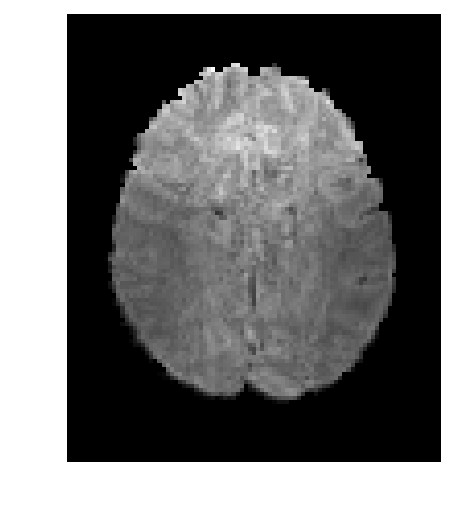

In [50]:
# And examining the dataobj will take awhile to load from disk...
#bold_mean = np.mean(bold_image.dataobj, axis=-1)

figsize = (imarr.shape[0]/100, imarr.shape[1]/100)
(fig,ax) = plt.subplots(1,1, figsize=figsize)
ax.imshow(bold_image.dataobj[:,:,50,600].T, cmap='gray')
ax.axis('off')
ax.invert_yaxis()
fig.subplots_adjust(0,0,1,1,0,0)

### Simulated/Example BOLD Timecourses

In [78]:
# Setup; our experiment is faces versus other stuff
t = np.arange(300) # 300 TRs
# we display something for 2 seconds then have 2 seconds of blanks;
# we start with 5 seconds of blank and end with 5 seconds of blank
stim_on_times = np.arange(5, len(t) - 4, 4) # when a stim comes on
stim_count = len(stim_on_times)
blanks = t * 0
# suppose we show half faces and half other images; get a random shuffle
stim_order = np.random.choice(['face','nonface'], stim_count)
faces    = (stim_order == 'face')
nonfaces = (stim_order == 'nonface')
face_stim = np.array(blanks)
face_stim[stim_on_times[faces]] = 1
face_stim[stim_on_times[faces]+1] = 1
nonface_stim = np.array(blanks)
nonface_stim[stim_on_times[nonfaces]] = 1
nonface_stim[stim_on_times[nonfaces]+1] = 1

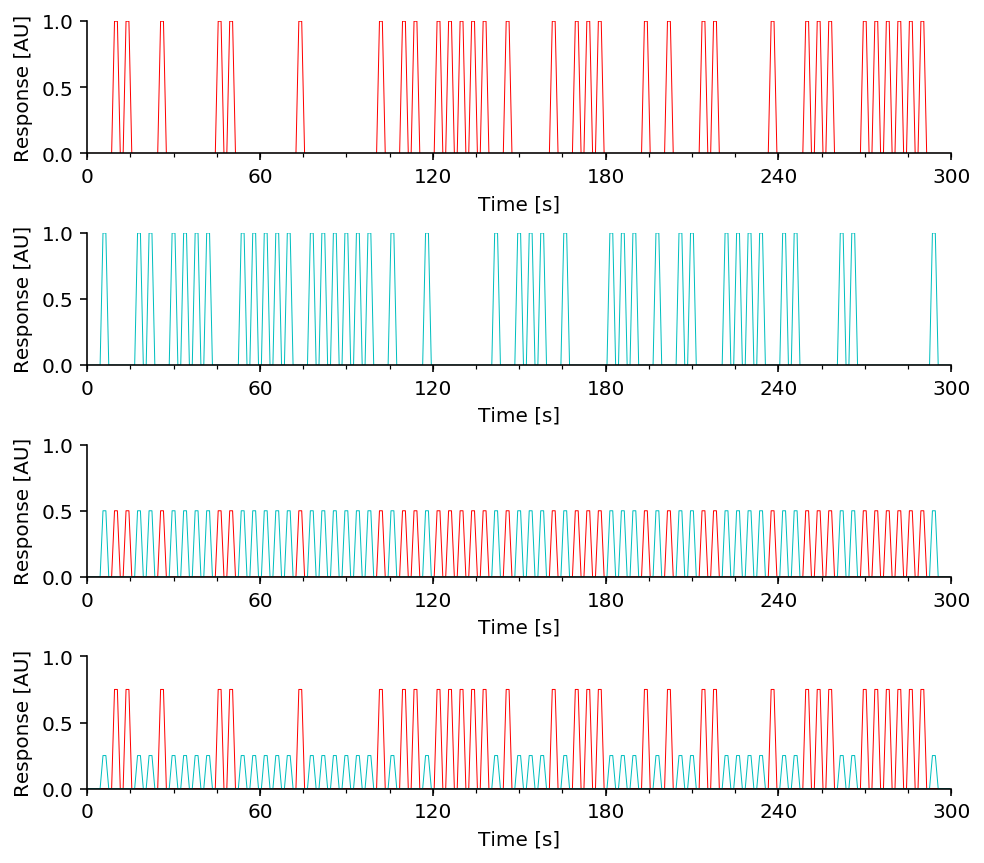

In [93]:
(fig,axs) = plt.subplots(4,1, figsize=(6, 5.33))

for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Response [AU]')
    ax.set_xlim([0,300])
    ax.set_ylim([0,1.001])
    ax.set_xticks(np.arange(0,301,60))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(15))

# First, timeplot of stimuli
axs[0].plot(t+0.5, face_stim,         'r-', lw=0.5)
axs[1].plot(t+0.5, nonface_stim,      'c-', lw=0.5)
axs[2].plot(t+0.5, 0.5*face_stim,     'r-', lw=0.5)
axs[2].plot(t+0.5, 0.5*nonface_stim,  'c-', lw=0.5)
axs[3].plot(t+0.5, 0.75*face_stim,    'r-', lw=0.5)
axs[3].plot(t+0.5, 0.25*nonface_stim, 'c-', lw=0.5)
fig.subplots_adjust(0,0,1,1,0.6,0.6)

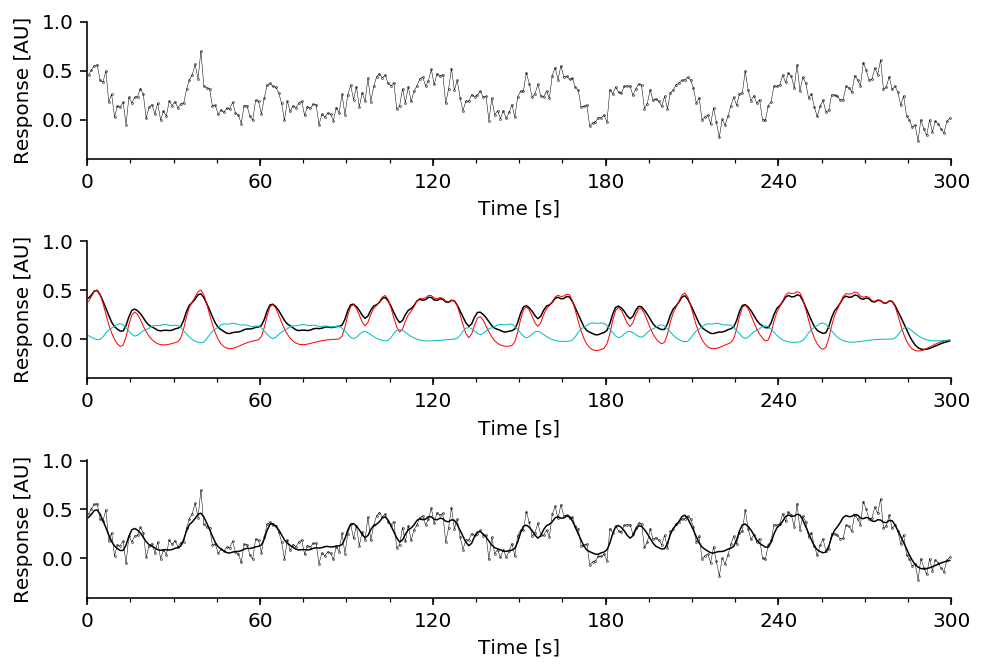

In [121]:
neural_sim = 0.75*face_stim + 0.25*nonface_stim
# add gaussian noise
neural_sim_noisy = neural_sim + np.random.randn(len(t))*0.05
# convolve with the HRF
hrf = popeye.utilities.double_gamma_hrf(0.25, 1)
bold_sim = np.convolve(hrf, neural_sim, mode='same')
bold_sim_noisy = np.convolve(hrf, neural_sim_noisy, mode='same')
bold_sim_noisy += np.random.randn(len(t))*0.075
# make the same simulations for faces only and nonfaces only
face_sim    = np.convolve(hrf, face_stim,    mode='same')
nonface_sim = np.convolve(hrf, nonface_stim, mode='same')

(fig,axs) = plt.subplots(3,1, figsize=(6, 4))

for ax in axs:
    for sp in ['top','right']:
        ax.spines[sp].set_visible(False)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Response [AU]')
    ax.set_xlim([0,300])
    ax.set_ylim([-0.4,1.001])
    ax.set_xticks(np.arange(0,301,60))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(15))

# First, timeplot of stimuli
axs[0].plot(t+0.5, bold_sim_noisy,     'k.-', lw=0.25, ms=0.5)
axs[1].plot(t+0.5, bold_sim,           'k-',  lw=0.75)
axs[1].plot(t+0.5, 0.75*face_sim,      'r-',  lw=0.5)
axs[1].plot(t+0.5, 0.25*nonface_sim,   'c-',  lw=0.5)
axs[2].plot(t+0.5, bold_sim_noisy,     'k.-', lw=0.25, ms=0.5)
axs[2].plot(t+0.5, bold_sim,           'k-',  lw=0.75)
fig.subplots_adjust(0,0,1,1,0.6,0.6)

### Example Retinotopic Maps

In [123]:
sub = ny.hcp_subject(111312)
ny.cortex_plot(sub.lh.surfaces['inflated'], color='prf_eccentricity',
               mask=('prf_variance_explained', 0.04, 1))
ipv.show()

/data/local/hcp/subjects/111312/T1w/111312/surf/lh.white hcp-openaccess/HCP_1200/111312/T1w/111312/surf/lh.white
/data/local/hcp/subjects/111312/MNINonLinear/fsaverage_LR32k/111312.L.white_MSMAll.32k_fs_LR.surf.gii hcp-openaccess/HCP_1200/111312/MNINonLinear/fsaverage_LR32k/111312.L.white_MSMAll.32k_fs_LR.surf.gii
/data/local/hcp/subjects/111312/MNINonLinear/fsaverage_LR59k/111312.L.white_1.6mm_MSMAll.59k_fs_LR.surf.gii hcp-openaccess/HCP_1200/111312/MNINonLinear/fsaverage_LR59k/111312.L.white_1.6mm_MSMAll.59k_fs_LR.surf.gii
/data/local/hcp/subjects/111312/T1w/Native/111312.L.inflated.native.surf.gii hcp-openaccess/HCP_1200/111312/T1w/Native/111312.L.inflated.native.surf.gii
/data/local/hcp/subjects/111312/MNINonLinear/fsaverage_LR59k/111312.L.sphere.59k_fs_LR.surf.gii hcp-openaccess/HCP_1200/111312/MNINonLinear/fsaverage_LR59k/111312.L.sphere.59k_fs_LR.surf.gii
/data/local/hcp/subjects/111312/MNINonLinear/Native/111312.L.sphere.MSMAll.native.surf.gii hcp-openaccess/HCP_1200/111312/MNI

In [142]:
sub = ny.hcp_subject(111312)
ny.cortex_plot(sub.lh.surfaces['very_inflated'], color='prf_polar_angle',
               mask=('prf_variance_explained', 0.04, 1))
ipv.show()

/data/local/hcp/subjects/111312/T1w/Native/111312.L.very_inflated.native.surf.gii hcp-openaccess/HCP_1200/111312/T1w/Native/111312.L.very_inflated.native.surf.gii
